In [1]:
import wandb

wandb.login()
# #a91efb0c33ce534255b3e79b1359fea833adc893

wandb: Currently logged in as: rahul107456 (WB-D). Use `wandb login --relogin` to force relogin


True

In [2]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="MyGPT2-Local",
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
import pandas as pd

main_df = pd.read_csv("dataset.csv")
main_df = main_df.drop(["split"], axis=1)
main_df["label"] = main_df["label"].map({"pos": 0, "neg": 1})
main_df.head()


,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,0
1,Homelessness (or Houselessness as George Carli...,0
2,Brilliant over-acting by Lesley Ann Warren. Be...,0
3,This is easily the most underrated film inn th...,0
4,This is not the typical Mel Brooks film. It wa...,0


In [4]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
    frac=1, random_state=123
    ).reset_index(drop=True)              
    train_end = int(len(df) * train_frac)         
    validation_end = train_end + int(len(df) * validation_frac)
    test_end = int(len(df) * 0.01)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[1-test_end: ] #df[validation_end:]
    return train_df, validation_df, test_df 

train_df, validation_df, test_df = random_split(
main_df, 0.06, 0.02)                    
#4

In [5]:
train_df.to_csv("train_sents.csv", index=None)
validation_df.to_csv("validation_sents.csv", index=None)
test_df.to_csv("test_sents.csv", index=None)


In [6]:
train_df

,text,label
0,"""It's all up to you, Ed?"" ""Now you get to play...",0
1,Let's see. This movie is many things to differ...,1
2,I just love this show.It's so funny and cool.K...,0
3,This interesting Giallo boosts a typical but s...,0
4,"Very intelligent language usage of Ali, which ...",0
...,...,...
2995,"Like many, this dung heap caught my eye while ...",1
2996,"If you read Errol Flynn's autobiography, My Wi...",1
2997,Such a delightful movie! Very heart warming. O...,0
2998,The Academy Award winning 'Kramer vs. Kramer' ...,0


In [7]:

validation_df

,text,label
3000,I haven't seen any other films by Antonioni an...,1
3001,I bought this movie and after I watched it I d...,1
3002,I have always been a fan of the show so I'll a...,0
3003,I realize it's a small statistical sampling (8...,1
3004,Despite the solid performance of Penelope Ann ...,1
...,...,...
3995,By Hook or By Crook is a tremendously innovati...,0
3996,"What a production, what a waste of screen-time...",1
3997,The debut that plucked from obscurity one of t...,0
3998,"Okay, I just had to sound off on this one... L...",1


In [8]:
test_df

,text,label
49501,I classify this as the worst movie of all time...,1
49502,A scientist on an island is in deep sorrow abo...,1
49503,I thought the children in the show did a very ...,0
49504,This film was a new direction for Natalie Port...,0
49505,"I LOVED this movie. You can't buy it, rent it,...",0
...,...,...
49995,I just purchased and viewed the DVD of this fi...,0
49996,Well the reason for seeing it in the cinema wa...,1
49997,Normally I'm not motivated to write reviews. B...,1
49998,I'm rating this pretty high just because of Sa...,0


In [9]:
train_df.shape[0]

3000

In [10]:
wandb.log({"Train Size" : train_df.shape[0],
           "Test Size" : test_df.shape[0],
           "Val Size" : validation_df.shape[0]})

In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
import torch
from torch.utils.data import Dataset

class MovieReviewsCollator(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
 #1
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

         # Use context length as max_length if not provided
        if max_length is None:
            self.max_length = 256  # cfg["context_length"]
        else:
            self.max_length = max_length
            
        # Truncate or pad encoded texts to match context length
        self.encoded_texts = [
            encoded_text[:self.max_length] 
            if len(encoded_text) > self.max_length 
            else encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        # self.encoded_texts = [
        #     encoded_text + [pad_token_id] * 
        #     (self.max_length - len(encoded_text))
        #     for encoded_text in self.encoded_texts
        # ]
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    def __len__(self):
        return len(self.data)
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [13]:
train_dataset = MovieReviewsCollator(
csv_file="train_sents.csv",
max_length=None,
tokenizer=tokenizer
)

In [14]:
val_dataset = MovieReviewsCollator(
csv_file="validation_sents.csv",
max_length=train_dataset.max_length,
tokenizer=tokenizer
)

test_dataset = MovieReviewsCollator(
csv_file="test_sents.csv",
max_length=train_dataset.max_length,
tokenizer=tokenizer
)

In [15]:
from torch.utils.data import DataLoader

num_workers = 0      #1
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
dataset=train_dataset,
batch_size=batch_size,
shuffle=True,
num_workers=num_workers,
drop_last=True,
)

val_loader = DataLoader(
dataset=val_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,
)

test_loader = DataLoader(
dataset=test_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,)

In [16]:
# train_loader

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape) 
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 256])
Label batch dimensions torch.Size([8])


In [17]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

375 training batches
125 validation batches
63 test batches


In [18]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
"vocab_size": 50257,         
"context_length": 1024,      
"drop_rate": 0.0,            
"qkv_bias": True             
}

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [19]:
wandb.log({"Model Chosen" : CHOOSE_MODEL})
wandb.log({"Config" : BASE_CONFIG})



In [20]:
import torch
import torch.nn as nn
from einops import rearrange, einsum
import torch.nn.functional as F

class GroupedQueryAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    #1
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)    #2
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def grouped_attention(self, query, key, value):
        """
        Computes grouped attention with queries, keys, and values.

        Args:
            query (torch.Tensor): Query tensor of shape (batch_size, seq_len, num_heads, head_dim).
            key (torch.Tensor): Key tensor of shape (batch_size, seq_len, num_kv_heads, head_dim).
            value (torch.Tensor): Value tensor of shape (batch_size, seq_len, num_kv_heads, head_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, num_kv_heads, head_dim).
        """
        num_head_groups = query.shape[2] // key.shape[2]

        query = rearrange(query, "b n h d -> b h n d")
        key = rearrange(key, "b s h d -> b h s d")
        value = rearrange(value, "b s h d -> b h s d")

        query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)

        scores = einsum(query, key, "b g h n d, b h s d -> b h n s")
        scale = query.size(-1) ** 0.5
        attention = F.softmax(scores / scale, dim=-1)

        out = einsum(attention, value, "b h n s, b h s d -> b h n d")
        out = rearrange(out, "b h n d -> b n h d")

        return out

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)         #3
        queries = self.W_query(x)    #3
        values = self.W_value(x)     #3

        #print(keys.shape,"12")

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #4
        
        #print(keys.shape,"11")
        
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   
   
        # Use grouped attention function here
        context_vec = self.grouped_attention(queries, keys, values)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)    #11
        return context_vec


In [21]:
class FeedForward(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),GELU(),
                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)
 def forward(self, x):
   return self.layers(x)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
            ))

In [22]:
# norm, attn, ff, norm
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
 #1
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #2
        shortcut = x         #3
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #4
        return x

In [23]:
class GPTModel(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

 def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    #1
    pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [24]:

def assign(left, right): # check if weights are compatible dimensions
 if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, "
    "Right: {right.shape}"
    )
 return torch.nn.Parameter(torch.tensor(right))

In [25]:
import numpy as np
def load_weights_into_gpt(gpt, params):           #1
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):     #2
        q_w, k_w, v_w = np.split(                            #3
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) 

In [26]:
from gpt_download import download_and_load_gpt2
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_feat

In [27]:
import tiktoken

def text_to_token_ids(text, tokenizer):
   encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
   encoded_tensor = torch.tensor(encoded).unsqueeze(0)    #1
   return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
   flat = token_ids.squeeze(0)                #2
   return tokenizer.decode(flat.tolist())

In [28]:
def generate_text_simple(model, idx,max_new_tokens, context_size): 
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]   
    with torch.no_grad():
        logits = model(idx_cond)
    
    logits = logits[:, -1, :]                   
    probas = torch.softmax(logits, dim=-1)          
    #3
    #4
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)   
    idx = torch.cat((idx, idx_next), dim=1)    
    return idx

In [29]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_feat

In [30]:
# replace FFNN with a linear layer for a classification head

for param in model.parameters():
    param.requires_grad = False


## Important Step

In [31]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
in_features=BASE_CONFIG["emb_dim"], 
out_features=num_classes
)

In [32]:
for param in model.trf_blocks[-1].parameters():
 param.requires_grad = True
for param in model.final_norm.parameters():
 param.requires_grad = True

In [33]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [34]:
with torch.no_grad():
 outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-0.5966,  0.6271],
         [-2.8117,  6.8164],
         [-2.0197,  5.6612],
         [-3.3210,  4.7156]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [35]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.3210,  4.7156]])


In [36]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [37]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [38]:
from sklearn.metrics import precision_score, f1_score

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    all_targets = []
    all_predictions = []
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]     #1
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

                    # Collect all targets and predictions for precision and F1
            all_targets.extend(target_batch.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())
        else:
            break
    
    # Calculate metrics
    accuracy = correct_predictions / num_examples
    precision = precision_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

        # else:
        #     break

    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1
    }
    #return correct_predictions / num_examples

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

#torch.manual_seed(123)

cuda


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_feat

In [40]:
train_accuracy = calc_accuracy_loader(
train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
test_loader, model, device, num_batches=10
)


c:\Users\gvikr\anaconda3\envs\Env1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gvikr\anaconda3\envs\Env1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gvikr\anaconda3\envs\Env1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
test_accuracy

{'accuracy': 0.5, 'precision': 0.25, 'f1_score': 0.3333333333333333}

In [42]:
print(f"Training accuracy: {train_accuracy['accuracy']*100:.2f}%")
print(f"Validation accuracy: {val_accuracy['accuracy']*100:.2f}%")
print(f"Test accuracy: {test_accuracy['accuracy']*100:.2f}%")

Training accuracy: 51.25%
Validation accuracy: 51.25%
Test accuracy: 50.00%


In [43]:
wandb.log({"Train Metrics Before Finetuning" : train_accuracy,
           "Test Metrics Before Finetuning" : test_accuracy,
           "Validation Metrics Before Finetuning" : val_accuracy,})

In [44]:
def calc_loss_batch(input_batch, target_batch, model, device):
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)
 logits = model(input_batch)[:, -1, :]    
 #1
 loss = torch.nn.functional.cross_entropy(logits, target_batch)
 return loss

In [45]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
 total_loss = 0.
 if len(data_loader) == 0:
     return float("nan")
 elif num_batches is None:
    num_batches = len(data_loader)
 else:                                       
 #1
    num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
        input_batch, target_batch, model, device
        )
            total_loss += loss.item()
        else:
            break
 return total_loss / num_batches

In [46]:
with torch.no_grad():                
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.691
Validation loss: 2.781
Test loss: 3.132


In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
 model.eval()
 with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
    )
 model.train()
 return train_loss, val_loss

In [48]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []   #1
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):    #2
        model.train()             #3
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                      #4
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()                          #5
            optimizer.step()                          #6
            examples_seen += input_batch.shape[0]    #7
            global_step += 1
 #8
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

            wandb.log({"Epoch": epoch+1})
            wandb.log({"train loss": train_loss})
            wandb.log({"val loss": val_loss})
            wandb.log({"learning_rate": optimizer.param_groups[0]["lr"]})    
 #9
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy['accuracy']*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy['accuracy']*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [49]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, train_accs, val_accs, examples_seen = \
train_classifier_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=10,
eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.915, Val loss 2.656
Ep 1 (Step 000010): Train loss 2.500, Val loss 1.658
Ep 1 (Step 000020): Train loss 1.190, Val loss 1.445
Ep 1 (Step 000030): Train loss 1.182, Val loss 1.420
Ep 1 (Step 000040): Train loss 0.943, Val loss 1.228
Ep 1 (Step 000050): Train loss 0.705, Val loss 1.071
Ep 1 (Step 000060): Train loss 0.887, Val loss 1.083
Ep 1 (Step 000070): Train loss 0.659, Val loss 1.014
Ep 1 (Step 000080): Train loss 0.796, Val loss 0.969
Ep 1 (Step 000090): Train loss 0.714, Val loss 0.947
Ep 1 (Step 000100): Train loss 0.795, Val loss 0.990
Ep 1 (Step 000110): Train loss 0.668, Val loss 0.972
Ep 1 (Step 000120): Train loss 0.676, Val loss 0.919
Ep 1 (Step 000130): Train loss 0.724, Val loss 0.908
Ep 1 (Step 000140): Train loss 0.811, Val loss 0.890
Ep 1 (Step 000150): Train loss 0.724, Val loss 0.881
Ep 1 (Step 000160): Train loss 0.679, Val loss 0.898
Ep 1 (Step 000170): Train loss 0.650, Val loss 0.907
Ep 1 (Step 000180): Train loss 0.748, Val loss

In [50]:
train_accs

[{'accuracy': 0.65,
  'precision': 0.6699999999999999,
  'f1_score': 0.6446969696969698},
 {'accuracy': 0.75, 'precision': 0.75, 'f1_score': 0.75}]

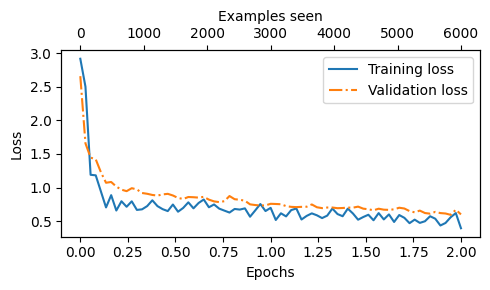

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
 #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
 #2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)    #3
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()             #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

     # Save to file
    file_name = f"{label}-plot.pdf"
    plt.savefig(file_name)
    plt.show()

    # Log to WandB
    wandb.log({f"{label}_plot": wandb.Image(fig)})
    
    # Close the figure to free memory
    plt.close(fig)

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [52]:
import matplotlib.pyplot as plt
import wandb

def plot_values(
        epochs_seen, examples_seen, train_metrics, val_metrics):
    """
    Plot training and validation metrics over epochs and log them to WandB.

    Args:
        epochs_seen (torch.Tensor): Tensor of epoch values.
        examples_seen (torch.Tensor): Tensor of examples seen values.
        train_metrics (list of dict): List of training metrics for each epoch.
        val_metrics (list of dict): List of validation metrics for each epoch.
    """
    # Extract metric names from the dictionaries
    metric_names = train_metrics[0].keys()
    
    # Iterate over each metric
    for metric_name in metric_names:
        # Extract the values for the current metric
        train_values = [epoch[metric_name] for epoch in train_metrics]
        val_values = [epoch[metric_name] for epoch in val_metrics]

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(5, 3))
        
        # Plot training and validation values
        ax1.plot(epochs_seen, train_values, label=f"Training {metric_name}")
        ax1.plot(
            epochs_seen, val_values, linestyle="-.",
            label=f"Validation {metric_name}"
        )
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel(metric_name.replace("_", " ").capitalize())
        ax1.legend()
        
        # Add secondary x-axis for examples seen
        ax2 = ax1.twiny()
        ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot
        ax2.set_xlabel("Examples seen")
        
        # Adjust layout and save the figure
        fig.tight_layout()
        file_name = f"{metric_name.replace('_', '-')}-plot.pdf"
        plt.savefig(file_name)
        plt.show()

        # Log to WandB
        wandb.log({f"{metric_name}_plot": wandb.Image(fig)})

        # Close the figure to free memory
        plt.close(fig)


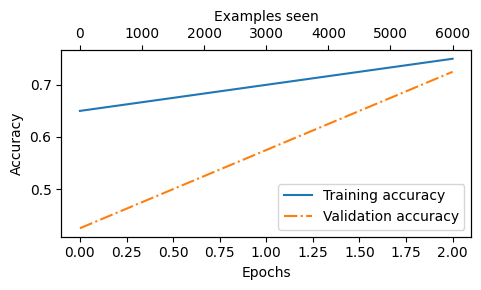

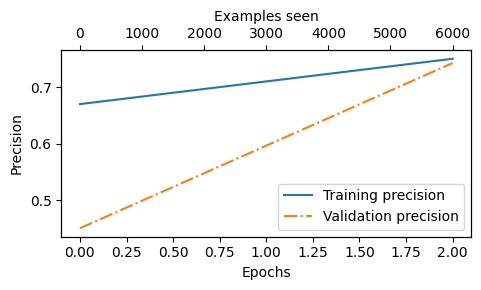

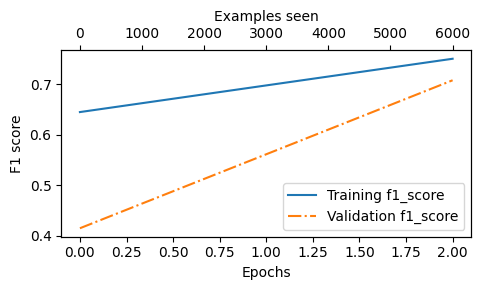

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, num_epochs)
examples_seen_tensor = torch.linspace(0, examples_seen, num_epochs)

# Call the function
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs)

In [58]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

train_accuracy

{'accuracy': 0.745,
 'precision': 0.7747703459466977,
 'f1_score': 0.7368100230384924}

In [59]:
wandb.log({"Train Metrics After Finetuning" : train_accuracy,
           "Test Metrics After Finetuning" : test_accuracy,
           "Validation Metrics After Finetuning" : val_accuracy,})

In [60]:
# Finish W&B run
wandb.finish()

Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
Test Size,▁
Train Size,▁
Val Size,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val loss,██▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁
Epoch,2
Model Chosen,gpt2-small (124M)
Test Size,499
Train Size,3000


In [47]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)          #1
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(              #2
        max_length, supported_context_length
    )]
    input_ids += [pad_token_id] * (max_length - len(input_ids))    #3
    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)              #4
    with torch.no_grad():                                #5
        logits = model(input_tensor)[:, -1, :]     #6
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"     #7

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
 )
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

In [ ]:
text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)
print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

In [50]:
# torch.save(model.state_dict(), "review_classifier.pth")

In [51]:
# model_state_dict = torch.load("review_classifier.pth, map_location=device")
#  model.load_state_dict(model_state_dict)